In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#check Cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [3]:
#load X_train array with 'open, volume, MACD, Signal, RSI, variance, crossover' as input features
X_train = np.load('data/X_train_array.npy')  

Y_train_raw = pd.read_csv('data/Y_train.csv') #construct Y_train_array

#Modify Y_train_raw such that the length matches the length of X_train
Y_train_raw = Y_train_raw.loc[len(Y_train_raw)-X_train.shape[0]:].reset_index(drop=True)

Y_train = Y_train_raw.to_numpy()

print('shape of X_train_array:',X_train.shape)
print('shape of Y_train_array:',Y_train.shape)

shape of X_train_array: (13293, 120, 7)
shape of Y_train_array: (13293, 9)


In [4]:
#Pick the latest 10 days for testing. There are 211 data points for each day.
n=10
data_x_train = X_train[:-211*n]
data_y_train = Y_train[:-211*n,0].astype(np.float64)     #Train/Test the High values
data_x_val = X_train[-211*n:]         #Change 0 to 1/2/3/4/5 to train/test the Low/Exact/High rate/Low rate/Exact rate
data_y_val = Y_train[-211*n:,0].astype(np.float64)

print('shape of X_train:', data_x_train.shape)
print('shape of X_val:', data_x_val.shape)


shape of X_train: (11183, 120, 7)
shape of X_val: (2110, 120, 7)


In [5]:
# normalization
scaler_x = StandardScaler()
scaler_y = MinMaxScaler()

data_x_train_s = scaler_x.fit_transform(data_x_train.reshape(-1,data_x_train.shape[-1])).reshape(data_x_train.shape)
data_x_val_s = scaler_x.transform(data_x_val.reshape(-1,data_x_val.shape[-1])).reshape(data_x_val.shape)
data_y_train_s = scaler_y.fit_transform(data_y_train.reshape(-1,1))
data_y_val_s = scaler_y.transform(data_y_val.reshape(-1,1))
print(data_y_val_s[:10].ravel()) #first 10 elements in data_y_val_s


[0.31072857 0.31351069 0.31351069 0.31657103 0.31664058 0.31664058
 0.31664058 0.31664058 0.31664058 0.31664058]


In [18]:
#Dataset and Dataloader
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(data_x_train_s, data_y_train_s)
dataset_val = TimeSeriesDataset(data_x_val_s, data_y_val_s)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

batch_size=128

train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)


Train data shape (11183, 120, 7) (11183, 1)
Validation data shape (2110, 120, 7) (2110, 1)


In [10]:
#LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)  
        self.linear_1 = nn.Linear(num_layers * hidden_size, 32)
        self.relu = nn.ReLU()      
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(32, output_size)
        
    def forward(self, x):
        batchsize = x.shape[0]

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)  
        x = self.relu(x)
        x = self.dropout(x)
        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        # layer 2       
        predictions = self.linear_2(x)

        return predictions


In [8]:
#Test function indicating testing result for each epoch
#Return inverse-transformed predicted values and MAE
def test(dataset, data_val):
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    predicted_val = np.array([]).reshape(0, output_size)
    
    model.eval()
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(dl):
            x = x.to(device)
            out = model(x)
            out = out.cpu().detach().numpy()
            predicted_val = np.concatenate((predicted_val, out), axis=0)
    
    return (scaler_y.inverse_transform(predicted_val.ravel().reshape(-1,1)).ravel(),
            mean_absolute_error(data_val, scaler_y.inverse_transform(predicted_val.ravel().reshape(-1,1)).ravel()))

In [19]:
#Trainning
input_size = 7 # we are using open, volume, MACD, Signal, RSI, variance, crossover as input features
hidden_size = 64
num_layers = 2
dropout = 0.1
output_size = 1

model = LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
                  output_size = output_size, dropout = dropout).to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

mae_train = []
mae_val = []

for epoch in range(50):  
    
    running_loss = 0.0
    
    model.train()
    
    for i, data in enumerate(train_dl):

        x, y = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs.contiguous(), y.contiguous())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%10==0:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss:.6f}')
        running_loss = 0.0        
    
    #store the MAE for train and val data
    mae_train.append(test(dataset_train, data_y_train)[1])
    mae_val.append(test(dataset_val, data_y_val)[1])
    
    scheduler.step()

print('Finished Training')


[1, 1] loss: 0.383259
[1, 11] loss: 0.286259
[1, 21] loss: 0.090442
[1, 31] loss: 0.018660
[1, 41] loss: 0.010424
[1, 51] loss: 0.010896
[1, 61] loss: 0.006549
[1, 71] loss: 0.005805
[1, 81] loss: 0.005336
[2, 1] loss: 0.005125
[2, 11] loss: 0.006179
[2, 21] loss: 0.007574
[2, 31] loss: 0.004978
[2, 41] loss: 0.004471
[2, 51] loss: 0.006217
[2, 61] loss: 0.004435
[2, 71] loss: 0.004034
[2, 81] loss: 0.003615
[3, 1] loss: 0.006144
[3, 11] loss: 0.003996
[3, 21] loss: 0.004220
[3, 31] loss: 0.004468
[3, 41] loss: 0.003712
[3, 51] loss: 0.003823
[3, 61] loss: 0.003347
[3, 71] loss: 0.003388
[3, 81] loss: 0.004629
[4, 1] loss: 0.002966
[4, 11] loss: 0.004972
[4, 21] loss: 0.002673
[4, 31] loss: 0.004350
[4, 41] loss: 0.003674
[4, 51] loss: 0.002841
[4, 61] loss: 0.002727
[4, 71] loss: 0.003041
[4, 81] loss: 0.004559
[5, 1] loss: 0.003441
[5, 11] loss: 0.002812
[5, 21] loss: 0.003873
[5, 31] loss: 0.002525
[5, 41] loss: 0.003171
[5, 51] loss: 0.003703
[5, 61] loss: 0.002793
[5, 71] loss: 0.

[39, 61] loss: 0.001100
[39, 71] loss: 0.000766
[39, 81] loss: 0.000583
[40, 1] loss: 0.000746
[40, 11] loss: 0.001155
[40, 21] loss: 0.000815
[40, 31] loss: 0.000782
[40, 41] loss: 0.000748
[40, 51] loss: 0.000982
[40, 61] loss: 0.000989
[40, 71] loss: 0.000856
[40, 81] loss: 0.000844
[41, 1] loss: 0.001042
[41, 11] loss: 0.000771
[41, 21] loss: 0.000802
[41, 31] loss: 0.000773
[41, 41] loss: 0.000710
[41, 51] loss: 0.000661
[41, 61] loss: 0.000932
[41, 71] loss: 0.001113
[41, 81] loss: 0.001074
[42, 1] loss: 0.000636
[42, 11] loss: 0.000711
[42, 21] loss: 0.000734
[42, 31] loss: 0.001282
[42, 41] loss: 0.000553
[42, 51] loss: 0.000667
[42, 61] loss: 0.000932
[42, 71] loss: 0.000977
[42, 81] loss: 0.001017
[43, 1] loss: 0.001010
[43, 11] loss: 0.000652
[43, 21] loss: 0.000948
[43, 31] loss: 0.000800
[43, 41] loss: 0.000753
[43, 51] loss: 0.000721
[43, 61] loss: 0.001086
[43, 71] loss: 0.001401
[43, 81] loss: 0.000609
[44, 1] loss: 0.000838
[44, 11] loss: 0.001255
[44, 21] loss: 0.0008

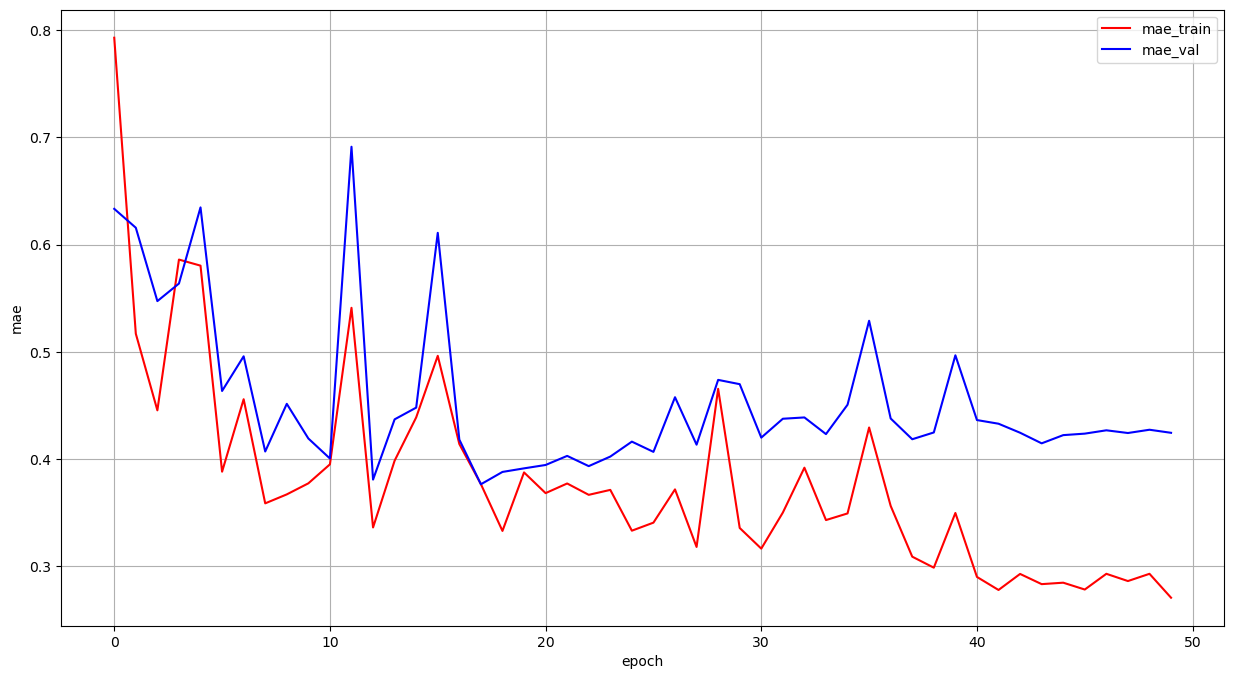

In [20]:
#Draw MAE-epoch graph
plt.figure(figsize=(15,8))

plt.plot(range(len(mae_train)), mae_train,'r',label='mae_train')
plt.plot(range(len(mae_val)), mae_val,'b',label='mae_val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.grid()
plt.show()

In [21]:
#MAE of train and val for the last epoch. Here we are predicting 'High' values

print("LSTM mae train for high values prediction:", test(dataset_train, data_y_train)[1])
print("LSTM mae val for high values prediction:", test(dataset_val, data_y_val)[1])


LSTM mae train for high values prediction: 0.27086036581574596
LSTM mae val for high values prediction: 0.4245388767908813


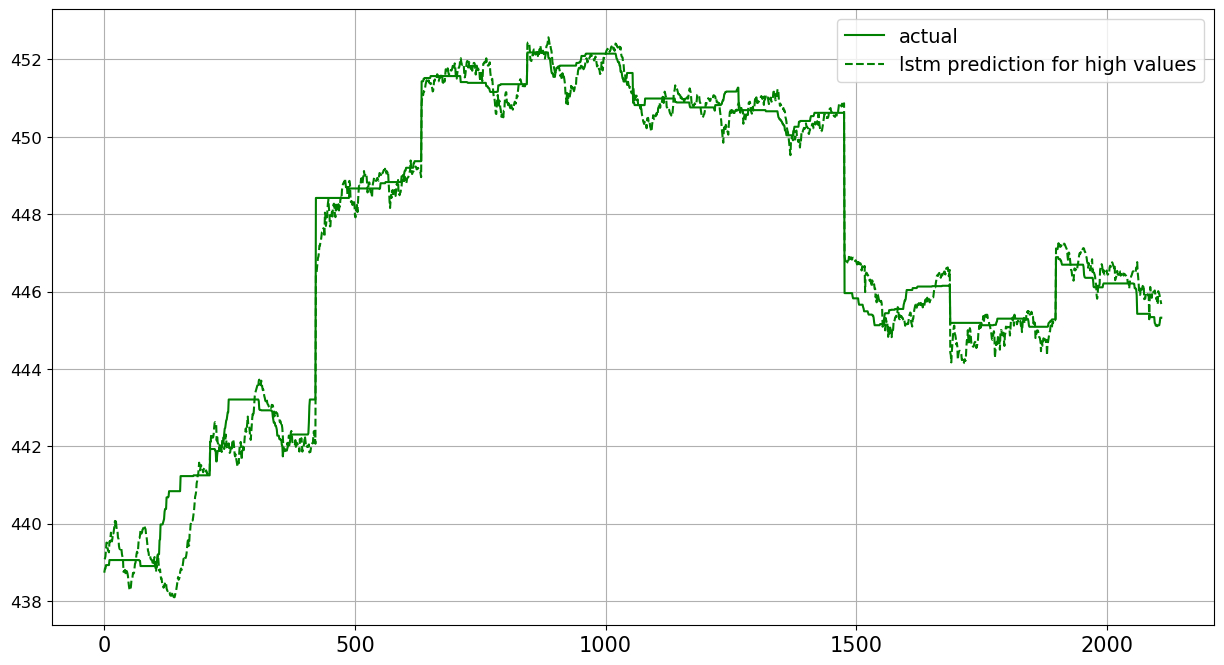

variance for high values prediction: 0.3530428987504222


In [22]:
#Draw the graph of the predicted values for the last epoch
lstm_pred = test(dataset_val, data_y_val)[0]

plt.figure(figsize=(15,8))
plt.plot(range(211*n), data_y_val,'g',label='actual')
plt.plot(range(211*n), lstm_pred ,'g--',label='lstm prediction for high values')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.grid()
plt.show()

print('variance for high values prediction:',(lstm_pred-data_y_val).var(ddof=0))

In [23]:
#Save the model parameters
#torch.save(model.state_dict(), 'lstm.pt')